## ESN predictions on MJO

Madden-Julian Oscillation:
- extreme weather event moving eastward
- traverses planet in 30-60 days
- intraseasonal (i.e. varies on a weekly basis, potentially several events each season)
- consists of 2 phases
    - Phase 1: enhanced rainfall (convective phase)
    - Phase 2: surpressed rainfall
    => dipole behavior, propagating eastward

In [19]:
cd("$(homedir())/Documents/Repos/enso_project.jl")
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\lisah\Documents\Repos\enso_project.jl`


In [ ]:
using ReservoirComputing, CSV, DataFrames, DynamicalSystems, Plots, enso_project, JLD2

Use ROMI (Real-time OLR MJO) index

In [21]:
header = ["year", "month", "day", "hour", "PC1 coeff", "PC2 coeff", "PC1+PC2 amplitude"]
data = CSV.read("data/mjo_data/mjo_romi.txt", DataFrame; delim=" ", ignorerepeated=true, header=header)

Row,year,month,day,hour,PC1 coeff,PC2 coeff,PC1+PC2 amplitude
,Int64,Int64,Int64,Int64,Float64,Float64,Float64
1,1991,1,1,0,0.12526,-0.06945,0.14323
2,1991,1,2,0,0.18542,-0.04887,0.19175
3,1991,1,3,0,0.2396,-0.03933,0.24281
4,1991,1,4,0,0.27446,0.0199,0.27518
5,1991,1,5,0,0.27714,0.07555,0.28725
6,1991,1,6,0,0.37999,0.23959,0.44922
7,1991,1,7,0,0.42803,0.26655,0.50424
8,1991,1,8,0,0.49339,0.34553,0.60235
9,1991,1,9,0,0.50765,0.41978,0.65873


In [22]:
pc1 = data[!,"PC1 coeff"]
pc2 = data[!,"PC2 coeff"]
amp = data[!, "PC1+PC2 amplitude"];

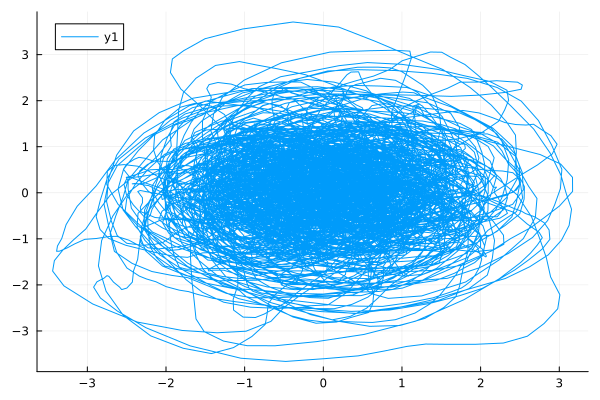

In [5]:
plot(pc1,pc2)

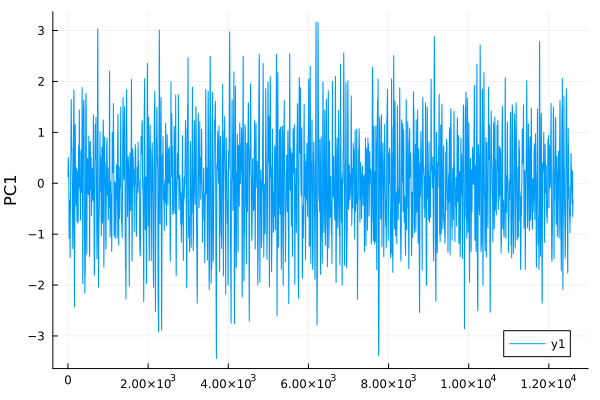

In [6]:
plot(pc1, ylabel="PC1")

## perform joint TDE on data

In [23]:
# concatenate observables (vertically, Vector)
data = [pc1; pc2];

In [24]:
# for now use same delay and embedding dimension for both observables
D, τ, E = optimal_separated_de(data) 

Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.


(8-dimensional StateSpaceSet{Float64} with 25115 points, 13, [0.0, 0.13281310058087145, 0.3550725710461058, 0.5377762607049774, 0.657384038612769, 0.7611128582289003, 0.8356384968268095, 0.8917533768251364, 0.937993121165926, 0.9647586893650312])

In [25]:
D = Matrix(transpose(Matrix(D)))

8×25115 Matrix{Float64}:
  0.12526   0.18542   0.2396    0.27446  …   0.18732   0.11945   0.04157
  0.41747   0.42911   0.38285   0.30184     -0.19376  -0.15557  -0.11545
 -0.76543  -0.87351  -0.95656  -1.05156     -0.40547  -0.50693  -0.57392
 -0.35186  -0.3604   -0.33645  -0.35614      0.24743   0.38886   0.50205
 -1.46235  -1.45142  -1.39516  -1.26362      0.43295   0.39148   0.2487
 -0.0543    0.05201   0.13738   0.2147   …  -0.21293  -0.12109  -0.11845
  1.45545   1.58408   1.63938   1.64463      0.02671   0.02144   0.02261
  0.90006   0.85395   0.84347   0.81304     -0.40887  -0.38871  -0.34477

In [34]:
emb_dim = size(D, 1)

8

In [26]:
# extract embedded data for both observables seperately
# D2 first because embedding shortens data at the end of the time series
D2 = D[:,length(pc1)+1:end]
D1 = D[:, 1:size(D2, 2)];

In [28]:
# vertically stack data, row 1 and row emb_dim +1 correspong to real time series
Ds = [D1; D2];

In [29]:
train_size= Int(floor(size(Ds,2) * 0.8))
test_size = 100
val_size= size(Ds,2) - train_size - test_size;

### train one ESN

In [30]:
Ds_train = Ds[:, 1:train_size]
Ds_val = Ds[:, train_size+1:train_size+val_size]
Ds_test = Ds[:, train_size+val_size+1:train_size+val_size+test_size];

In [31]:
spectral_radii = [0.8,0.9,1.0]
sparsities = [0.14,0.1,0.5]
input_scales = [0.1,1.0]
ridge_values = [0.0,1e-5, 1e-6]
reservoir_sizes = [500,700,1000]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values)

esn, W_out, val_loss = enso_project.cross_validate_esn(Ds_train, Ds_val, param_grid)

enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 69801.5689523886
enso_project.ESNHyperparams(700, 0.8, 0.14, 0.1, 0.0)
Validation loss = 65200.30861572437
enso_project.ESNHyperparams(1000, 0.8, 0.14, 0.1, 0.0)
Validation loss = 56563.574521911025
enso_project.ESNHyperparams(500, 0.8, 0.1, 0.1, 0.0)
Validation loss = 52050.43906360439
enso_project.ESNHyperparams(700, 0.8, 0.1, 0.1, 0.0)
Validation loss = 49573.18634531135


(ESN(16 => 700), OutputLayer successfully trained with output size: 16, 49573.18634531135)

In [53]:
# store esn for later purposes
@save "C:/Users/lisah/Documents/Repos/enso_project.jl/esn_saves/mjo_tde_joint.jld2" mjo_tde_joint=esn

@save "C:/Users/lisah/Documents/Repos/enso_project.jl/esn_saves/mjo_tde_joint_W.jld2" mjo_tde_joint_W=W_out

#### evaluate prediction

In [43]:
function esn_eval_pred_mjo(esn::ESN, W_out, test_data::Matrix, emb_dim::Int64)
    steps_to_predict = size(test_data,2)
    prediction = esn(Generative(steps_to_predict), W_out)
    return prediction[[1, emb_dim +1],:]
end

esn_eval_pred_mjo (generic function with 1 method)

In [44]:
prediction = esn_eval_pred_mjo(esn, W_out,Ds_test, emb_dim)

2×100 Matrix{Float64}:
 -1.28188   -1.12137   -0.953396  …  -0.866102   -0.755684  -0.618085
 -0.399317  -0.406401  -0.472043      0.0763022  -0.170707  -0.423715

#### plot

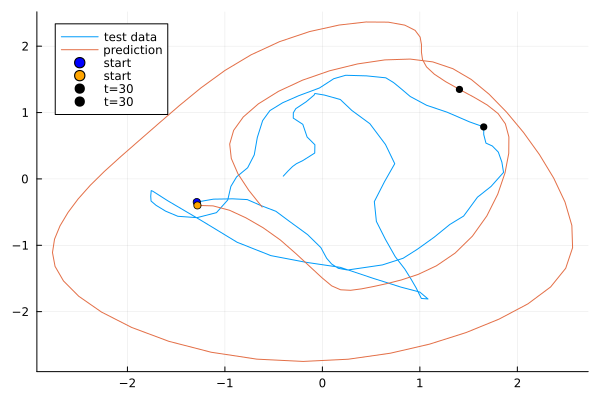

In [45]:
plot(Ds_test[1,:], Ds_test[9,:], label="test data")
plot!(prediction[1,:], prediction[2,:], label="prediction")
scatter!([Ds_test[1,1]], [Ds_test[9,1]], label="start", color=:blue, marker=:circle, markersize=4)
scatter!([prediction[1,1]], [prediction[2,1]], label="start", color=:orange, marker=:circle, markersize=4)
scatter!([Ds_test[1,30]], [Ds_test[9,30]], label="t=30", color=:black, marker=:circle, markersize=4)
scatter!([prediction[1,30]], [prediction[2,30]], label="t=30", color=:black, marker=:circle, markersize=4)

### train two ESNs

In [46]:
D1_train = D1[:, 1:train_size]
D1_val = D1[:, train_size+1:train_size+val_size]
D1_test = D1[:, train_size+val_size+1:train_size+val_size+test_size];

D2_train = D2[:, 1:train_size]
D2_val = D2[:, train_size+1:train_size+val_size]
D2_test = D2[:, train_size+val_size+1:train_size+val_size+test_size];

In [47]:
spectral_radii = [0.8,0.9,1.0]
sparsities = [0.14,0.1,0.5]
input_scales = [0.1,1.0]
ridge_values = [0.0,1e-5, 1e-6]
reservoir_sizes = [500,700,1000]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values)

esn_D1, W_out_D1, val_loss_D1 = enso_project.cross_validate_esn(D1_train, D1_val, param_grid)

enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 20244.36032834927
enso_project.ESNHyperparams(500, 0.8, 0.1, 0.1, 0.0)
Validation loss = 19126.08227253778
enso_project.ESNHyperparams(700, 0.8, 0.1, 0.1, 0.0)
Validation loss = 18551.64134254372


(ESN(8 => 700), OutputLayer successfully trained with output size: 8, 18551.64134254372)

In [48]:
spectral_radii = [0.8,0.9,1.0]
sparsities = [0.14,0.1,0.5]
input_scales = [0.1,1.0]
ridge_values = [0.0,1e-5, 1e-6]
reservoir_sizes = [500,700,1000]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values)

esn_D2, W_out_D2, val_loss_D2 = enso_project.cross_validate_esn(D2_train, D2_val, param_grid)

enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 16293.511351117058
enso_project.ESNHyperparams(700, 0.8, 0.1, 0.1, 0.0)
Validation loss = 14478.591464868223


(ESN(8 => 700), OutputLayer successfully trained with output size: 8, 14478.591464868223)

In [52]:
# store esn for later purposes
@save "C:/Users/lisah/Documents/Repos/enso_project.jl/esn_saves/mjo_tde_seperate_pc1.jld2" mjo_tde_seperate_pc1=esn_D1
@save "C:/Users/lisah/Documents/Repos/enso_project.jl/esn_saves/mjo_tde_seperate_pc2.jld2" mjo_tde_seperate_pc2=esn_D2 

@save "C:/Users/lisah/Documents/Repos/enso_project.jl/esn_saves/mjo_tde_seperate_pc1_W.jld2" mjo_tde_seperate_pc1_W=W_out_D1
@save "C:/Users/lisah/Documents/Repos/enso_project.jl/esn_saves/mjo_tde_seperate_pc2_W.jld2" mjo_tde_seperate_pc2_W=W_out_D2 

#### evaluate prediction

In [54]:
prediction_D1 = enso_project.esn_eval_pred(esn_D1, W_out_D1, D1_test)
prediction_D2 = enso_project.esn_eval_pred(esn_D2, W_out_D2, D2_test);

#### plot

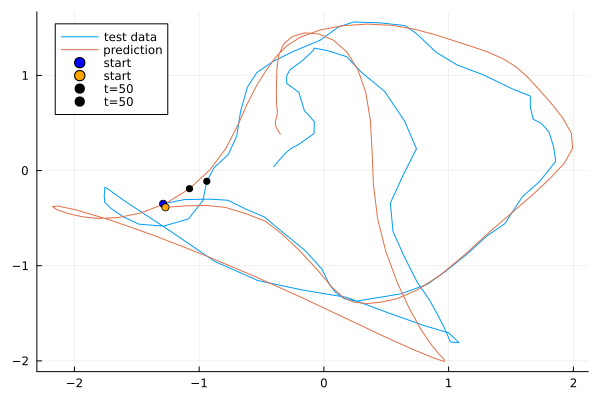

In [55]:
plot(D1_test[1,:], D2_test[1,:], label="test data")
plot!(prediction_D1, prediction_D2, label="prediction")
scatter!([D1_test[1,1]], [D2_test[1,1]], label="start", color=:blue, marker=:circle, markersize=4)
scatter!([prediction_D1[1]], [prediction_D2[1]], label="start", color=:orange, marker=:circle, markersize=4)
scatter!([D1_test[1,50]], [D2_test[1,50]], label="t=50", color=:black, marker=:circle, markersize=4)
scatter!([prediction_D1[50]], [prediction_D2[50]], label="t=50", color=:black, marker=:circle, markersize=4)

### compare both training approaches

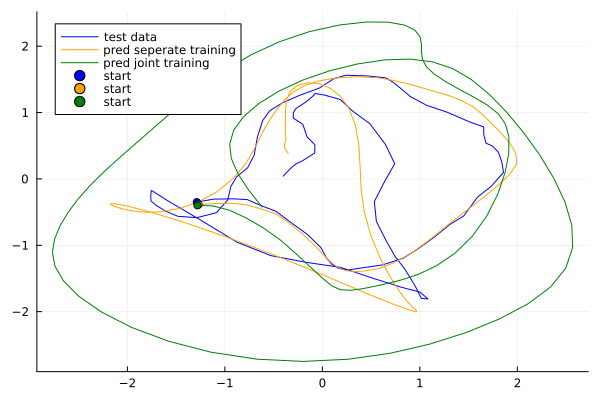

In [56]:
plot(D1_test[1,:], D2_test[1,:], label="test data", color=:blue)
plot!(prediction_D1, prediction_D2, label="pred seperate training", color=:orange)
plot!(prediction[1,:], prediction[2,:], label="pred joint training", color=:green)
scatter!([D1_test[1,1]], [D2_test[1,1]], label="start", color=:blue, marker=:circle, markersize=4)
scatter!([prediction_D1[1]], [prediction_D2[1]], label="start", color=:orange, marker=:circle, markersize=4)
scatter!([prediction[1,1]], [prediction[2,1]], label="start", color=:green, marker=:circle, markersize=4)

## perform seperate TDE on data

In [92]:
D_pc1, τ, E = optimal_separated_de(pc1)

Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.


(8-dimensional StateSpaceSet{Float64} with 12519 points, 12, [0.0, 0.14206960558503923, 0.3728222786384966, 0.5501688286055798, 0.6606134418271966, 0.7846649701571529, 0.8700289939093533, 0.9287571154255055, 0.9634918001728846, 0.9774712616957693])

In [89]:
D_pc2, τ, E = optimal_separated_de(pc2) 

Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.


(8-dimensional StateSpaceSet{Float64} with 12519 points, 12, [0.0, 0.14189146019484614, 0.3699954692167882, 0.5637911913260818, 0.6729937402208649, 0.78880584069318, 0.8615608100100905, 0.9153986023004472, 0.9484263294327188, 0.9718774474017636])

## evaluate performance metrics

In [78]:
[pc1 pc2]

12603×2 Matrix{Float64}:
  0.12526  -0.06945
  0.18542  -0.04887
  0.2396   -0.03933
  0.27446   0.0199
  0.27714   0.07555
  0.37999   0.23959
  0.42803   0.26655
  0.49339   0.34553
  0.50765   0.41978
  0.46603   0.45432
  0.43921   0.44696
  0.38635   0.44401
  0.36751   0.39319
  ⋮        
 -0.2696    0.10834
 -0.39975   0.06371
 -0.43881   0.00233
 -0.48935  -0.04809
 -0.58475  -0.16275
 -0.66268  -0.26311
 -0.6561   -0.27416
 -0.60538  -0.30815
 -0.53046  -0.34925
 -0.40529  -0.40887
 -0.33531  -0.38871
 -0.37026  -0.34477

### RMSE

In [ ]:
function rmse(prediction::AbstractMatrix, test_data::AbstractMatrix)
    mse = zeros(size(prediction,2))
    for i in 1:size(prediction, 1)
        mse = mse .+ (prediction[i,:] .- test_data[i, :]).^2
    end
    mse = mse ./ size(prediction, 2)
    return sqrt.(mse)
end

rmse (generic function with 2 methods)

In [97]:
[D1_test[1,:] D2_test[1,:]]'

2×100 adjoint(::Matrix{Float64}) with eltype Float64:
 -1.28849  -1.11756  -0.91923  -0.77048  …  -0.3055   -0.35227  -0.40133
 -0.3489   -0.30503  -0.30012  -0.3115       0.18732   0.11945   0.04157

In [98]:
[prediction_D1 prediction_D1]'

2×100 adjoint(::Matrix{Float64}) with eltype Float64:
 -1.2703  -1.10957  -0.93607  -0.791235  …  -0.389532  -0.383798  -0.349456
 -1.2703  -1.10957  -0.93607  -0.791235     -0.389532  -0.383798  -0.349456

In [105]:
rmse_val=rmse([prediction_D1 prediction_D2]', [D1_test[1,:] D2_test[1,:]]');

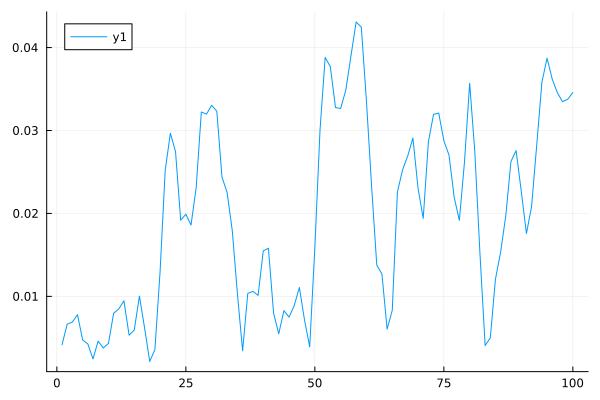

In [106]:
plot(rmse_val)